### BA Customer Review Analysis

In [1]:
# Importing necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
import time
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from collections import Counter
import plotly.express as px
from PIL import Image

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

#### Web Scraping

In [2]:
# Web scraping code for collecting BA customer reviews from airlinequality.com

# Base URL and page size for web scraping
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
page_size = 1000
i = 1
feedbacks=defaultdict(list)

# Loop for scraping reviews from multiple pages
while True:
    print(f'Scraping page {i}')
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'html.parser')

    # Checking if reviews exist on the page
    if elements := soup.find_all('article',{'itemprop':'review'}):
        for element in elements:
            
            # Extracting relevant information from each review element
            
            aircraft = element.find('td',{'class':"review-rating-header aircraft"})
            feedbacks['aircraft_type'].append(aircraft.find_next().get_text().strip() if aircraft else np.nan)
                
            type_of_traveller = element.find('td',{'class':"review-rating-header type_of_traveller"})
            feedbacks['traveller_type'].append(type_of_traveller.find_next().get_text().strip() if type_of_traveller else np.nan)
            
            seat_type = element.find('td',{'class':"review-rating-header cabin_flown"})
            feedbacks['seat_type'].append(seat_type.find_next().get_text().strip() if seat_type else np.nan)
            
            country = element.find('h3',class_="text_sub_header userStatusWrapper").contents[2].strip(' ()')
            feedbacks['country_living'].append(country)
            
            route = element.find('td',{'class':"review-rating-header route"})
            feedbacks['route'].append(route.find_next().get_text().strip() if route else np.nan)
                
            month_year = element.find('td',{'class':"review-rating-header date_flown"})
            feedbacks['month_year'].append(month_year.find_next().get_text().strip() if month_year else np.nan)

            recommend = element.find('td',{'class':"review-rating-header recommended"})
            feedbacks['recommended'].append(recommend.find_next().get_text().strip() if recommend else np.nan)
            
            rating_10 = element.find('span',{'itemprop':"ratingValue"})
            feedbacks['overall_rating_10'].append(rating_10.get_text() if rating_10 else np.nan)
            
            money_value = element.find('td',{'class':"review-rating-header value_for_money"})
            feedbacks['value_for_money'].append(len(money_value.find_next().find_all('span',{'class':'star fill'})) if money_value else np.nan)
            
            ground_service = element.find('td',{'class':"review-rating-header ground_service"})
            feedbacks['ground_service'].append(len(ground_service.find_next().find_all('span',{'class':'star fill'})) if ground_service else np.nan)

            seat_comfort = element.find('td',{'class':"review-rating-header seat_comfort"})
            feedbacks['seat_comfort'].append(len(seat_comfort.find_next().find_all('span',{'class':'star fill'})) if seat_comfort else np.nan)
            
            cabin_service = element.find('td',{'class':"review-rating-header cabin_staff_service"})
            feedbacks['cabin_staff_service'].append(len(cabin_service.find_next().find_all('span',{'class':'star fill'})) if cabin_service else np.nan)
            
            food_bev = element.find('td',{'class':"review-rating-header food_and_beverages"})
            feedbacks['food_beverage'].append(len(food_bev.find_next().find_all('span',{'class':'star fill'})) if food_bev else np.nan)
            
            ife = element.find('td',{'class':"review-rating-header inflight_entertainment"})
            feedbacks['in_flight_entertainment'].append(len(ife.find_next().find_all('span',{'class':'star fill'})) if ife else np.nan)
            
            wifi = element.find('td',{'class':"review-rating-header wifi_and_connectivity"})
            feedbacks['wifi_connectivity'].append(len(wifi.find_next().find_all('span',{'class':'star fill'})) if wifi else np.nan)

            feedbacks['reviews'].append(element.find('div',{'class':"text_content",'itemprop':"reviewBody"}).get_text().strip())
        i += 1
    else:
        print(f"---------->   {len(feedbacks['aircraft_type'])} total reviews")
        print('---------->   Scraping complete')
        break

Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
---------->   3734 total reviews
---------->   Scraping complete


In [3]:
# Creating a DataFrame from scraped feedbacks
df = pd.DataFrame(feedbacks)
df.head()

,aircraft_type,traveller_type,seat_type,country_living,route,month_year,recommended,overall_rating_10,value_for_money,ground_service,seat_comfort,cabin_staff_service,food_beverage,in_flight_entertainment,wifi_connectivity,reviews
0,NaN,Family Leisure,Economy Class,Ireland,Dublin to London Heathrow,January 2024,no,1,3,1.0,3.0,3.0,NaN,NaN,1.0,✅ Trip Verified | The plane was extremely dir...
1,NaN,Business,Economy Class,United Kingdom,Glasgow to London,January 2024,no,4,3,4.0,3.0,4.0,NaN,NaN,NaN,Not Verified | Overall journey wasn’t bad howe...
2,A350-1000,Solo Leisure,Economy Class,United Kingdom,Vancouver to London,January 2024,yes,9,5,5.0,4.0,5.0,3.0,4.0,4.0,✅ Trip Verified | Overall very satisfied. Gro...
3,A320,Business,Business Class,Spain,Heathrow to Madrid,October 2023,no,1,1,1.0,1.0,1.0,1.0,1.0,1.0,✅ Trip Verified | As always when I fly BA it ...
4,Boeing 777 -200,Couple Leisure,Business Class,United Kingdom,London to New York,November 2023,yes,9,4,5.0,5.0,5.0,5.0,5.0,NaN,✅ Trip Verified | First time using BA busines...


In [4]:
# Creating a directory to save the DataFrame as CSV
path='data'
if not os.path.exists(path):
    os.makedirs(path)
df.to_csv(os.path.join(path,'BA_reviews.csv'),index=False)

#### Cleaning & Preprocessing

In [2]:
# Reading the CSV file into a DataFrame
df = pd.read_csv('data/BA_reviews.csv')
df.head(5)

,aircraft_type,traveller_type,seat_type,country_living,route,month_year,recommended,overall_rating_10,value_for_money,ground_service,seat_comfort,cabin_staff_service,food_beverage,in_flight_entertainment,wifi_connectivity,reviews
0,NaN,Family Leisure,Economy Class,Ireland,Dublin to London Heathrow,January 2024,no,1.0,3,1.0,3.0,3.0,NaN,NaN,1.0,✅ Trip Verified | The plane was extremely dir...
1,NaN,Business,Economy Class,United Kingdom,Glasgow to London,January 2024,no,4.0,3,4.0,3.0,4.0,NaN,NaN,NaN,Not Verified | Overall journey wasn’t bad howe...
2,A350-1000,Solo Leisure,Economy Class,United Kingdom,Vancouver to London,January 2024,yes,9.0,5,5.0,4.0,5.0,3.0,4.0,4.0,✅ Trip Verified | Overall very satisfied. Gro...
3,A320,Business,Business Class,Spain,Heathrow to Madrid,October 2023,no,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,✅ Trip Verified | As always when I fly BA it ...
4,Boeing 777 -200,Couple Leisure,Business Class,United Kingdom,London to New York,November 2023,yes,9.0,4,5.0,5.0,5.0,5.0,5.0,NaN,✅ Trip Verified | First time using BA busines...


In [3]:
# Mapping 'Recommended' values to 1 and 0
df.loc[:,'recommended'] = df['recommended'].map({'no':0,'yes':1})

# Convert 'Recommended' to numeric, handling errors by coercing to NaN
df['recommended'] = pd.to_numeric(df['recommended'], errors='coerce')

# Remove rows where the third element of the 'Route' split is not NaN
df = df[~df['route'].str.split(' to ', expand=True)[2].notna()]

# Split 'Route' into 'From' and 'To' columns
df[['from','to']]=df['route'].str.split(' to ',expand=True)

df.drop(columns=['route'],axis=1,inplace=True)

# Extract the destination without 'via'
df['to'] = df['to'].str.split(' via ').str[0]

# Convert 'Month_Year' to datetime, handling errors by coercing to NaN
df['date'] = pd.to_datetime(df['month_year'], errors='coerce')

df.head(5)

,aircraft_type,traveller_type,seat_type,country_living,month_year,recommended,overall_rating_10,value_for_money,ground_service,seat_comfort,cabin_staff_service,food_beverage,in_flight_entertainment,wifi_connectivity,reviews,from,to,date
0,NaN,Family Leisure,Economy Class,Ireland,January 2024,0,1.0,3,1.0,3.0,3.0,NaN,NaN,1.0,✅ Trip Verified | The plane was extremely dir...,Dublin,London Heathrow,2024-01-01
1,NaN,Business,Economy Class,United Kingdom,January 2024,0,4.0,3,4.0,3.0,4.0,NaN,NaN,NaN,Not Verified | Overall journey wasn’t bad howe...,Glasgow,London,2024-01-01
2,A350-1000,Solo Leisure,Economy Class,United Kingdom,January 2024,1,9.0,5,5.0,4.0,5.0,3.0,4.0,4.0,✅ Trip Verified | Overall very satisfied. Gro...,Vancouver,London,2024-01-01
3,A320,Business,Business Class,Spain,October 2023,0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,✅ Trip Verified | As always when I fly BA it ...,Heathrow,Madrid,2023-10-01
4,Boeing 777 -200,Couple Leisure,Business Class,United Kingdom,November 2023,1,9.0,4,5.0,5.0,5.0,5.0,5.0,NaN,✅ Trip Verified | First time using BA busines...,London,New York,2023-11-01


In [4]:
# Shape of the DataFrame
df.shape

(3730, 18)

In [5]:
# Checking for duplicated rows
df.duplicated().sum()

2

In [6]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

df.shape

(3728, 18)

#### EDA

In [7]:
# Information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3728 entries, 0 to 3733
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   aircraft_type            1938 non-null   object        
 1   traveller_type           2957 non-null   object        
 2   seat_type                3727 non-null   object        
 3   country_living           3726 non-null   object        
 4   month_year               2950 non-null   object        
 5   recommended              3728 non-null   int64         
 6   overall_rating_10        3723 non-null   float64       
 7   value_for_money          3728 non-null   int64         
 8   ground_service           2882 non-null   float64       
 9   seat_comfort             3611 non-null   float64       
 10  cabin_staff_service      3599 non-null   float64       
 11  food_beverage            3336 non-null   float64       
 12  in_flight_entertainment  2576 non-null 

In [8]:
# Descriptive statistics of the DataFrame
df.describe()

,recommended,overall_rating_10,value_for_money,ground_service,seat_comfort,cabin_staff_service,food_beverage,in_flight_entertainment,wifi_connectivity,date
count,3728.000000,3723.000000,3728.000000,2882.000000,3611.000000,3599.000000,3336.000000,2576.000000,620.000000,2950
mean,0.404238,4.730056,2.687500,2.783137,2.872611,3.252014,2.715228,2.642081,1.924194,2018-06-14 03:39:39.661017088
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2014-07-01 00:00:00
25%,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2016-07-01 00:00:00
50%,0.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,2017-09-01 00:00:00
75%,1.000000,8.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,3.000000,2019-10-01 00:00:00
max,1.000000,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2024-01-01 00:00:00
std,0.490810,3.173545,1.471392,1.458849,1.361867,1.490047,1.441042,1.407883,1.353173,NaN


In [9]:
# Number of missing values in each column
df.isnull().sum()

aircraft_type              1790
traveller_type              771
seat_type                     1
country_living                2
month_year                  778
recommended                   0
overall_rating_10             5
value_for_money               0
ground_service              846
seat_comfort                117
cabin_staff_service         129
food_beverage               392
in_flight_entertainment    1152
wifi_connectivity          3108
reviews                       0
from                        775
to                          790
date                        778
dtype: int64

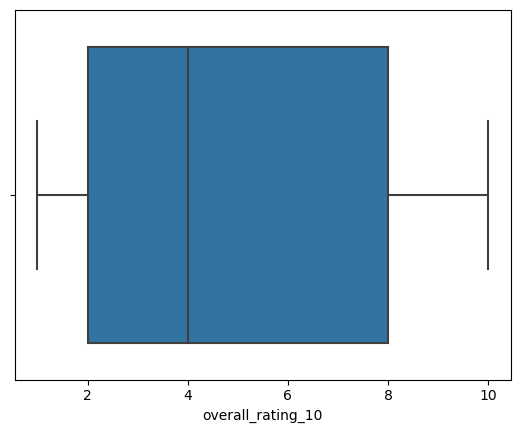

In [10]:
# Detecting OUtliers in overall rating
sns.boxplot(x=df['overall_rating_10'])
plt.show()

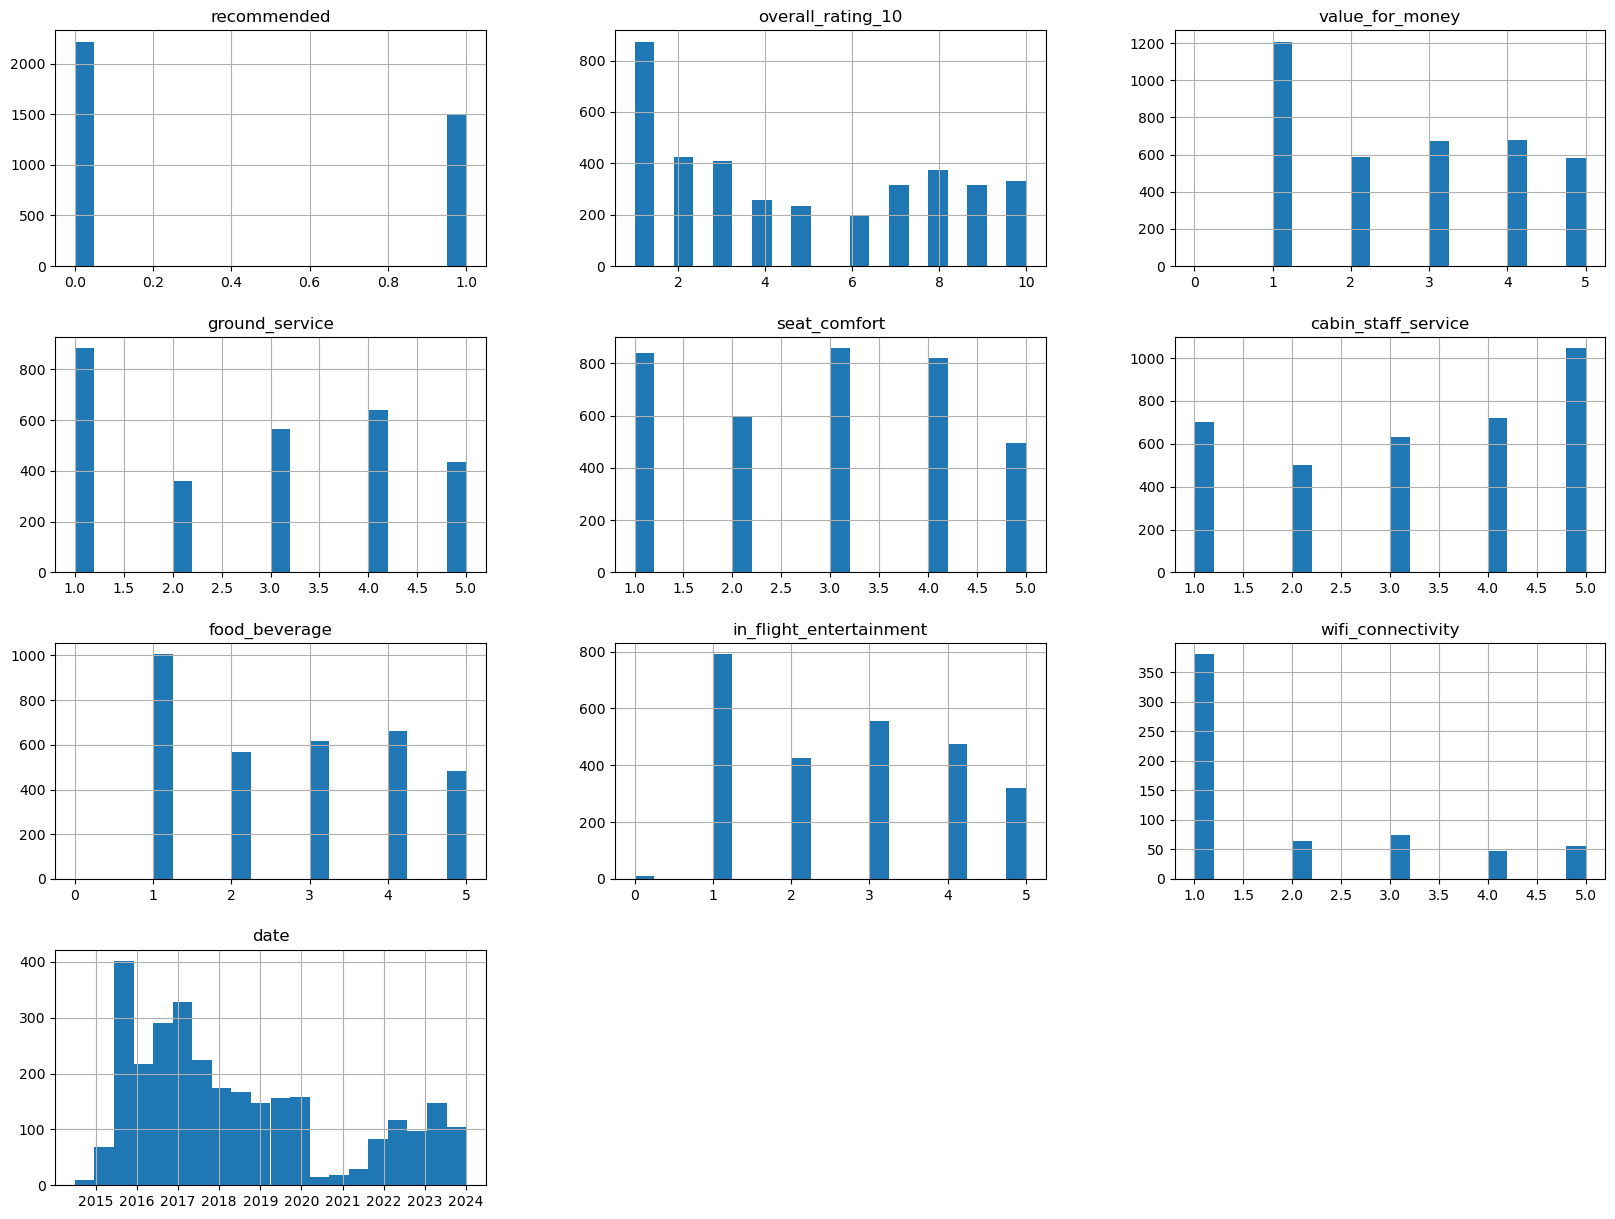

In [11]:
# Distribution of a dataset
df.hist(bins=20,figsize=(20,15))
plt.show()

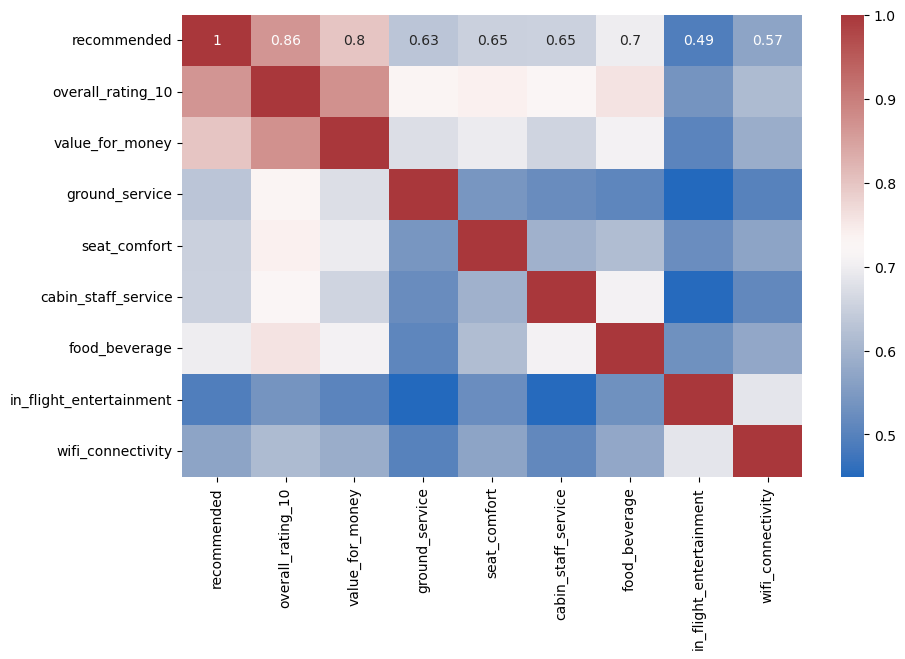

In [12]:
# Heat Map of Correlation Matrix
plt.figure(figsize=(10,6))
c = df.corr(numeric_only=True)
sns.heatmap(c,cmap="vlag",annot=True)
plt.show()

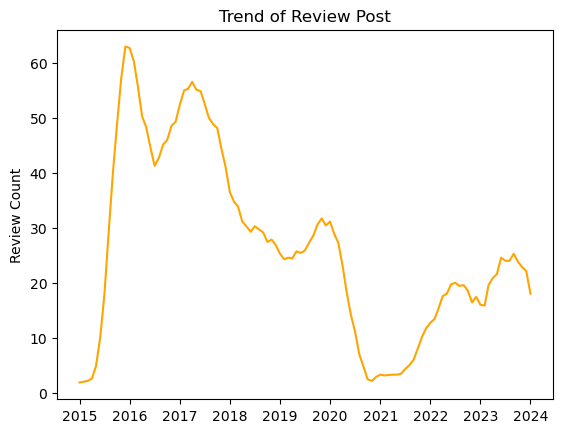

In [13]:
# Trend of Review Post
rolling_mean = df['date'].value_counts().sort_index().rolling(window=7).mean()

# Plot the smoothed curve
plt.plot(rolling_mean, color='orange')
plt.title('Trend of Review Post')
plt.ylabel('Review Count')
plt.show()

#### Preprocessing reviews

In [14]:
r = pd.DataFrame(df[['date','country_living','reviews']])
r.head()

,date,country_living,reviews
0,2024-01-01,Ireland,✅ Trip Verified | The plane was extremely dir...
1,2024-01-01,United Kingdom,Not Verified | Overall journey wasn’t bad howe...
2,2024-01-01,United Kingdom,✅ Trip Verified | Overall very satisfied. Gro...
3,2023-10-01,Spain,✅ Trip Verified | As always when I fly BA it ...
4,2023-11-01,United Kingdom,✅ Trip Verified | First time using BA busines...


In [15]:
# Checking for HTML tags in reviews
r['reviews'].apply(lambda x: bool(BeautifulSoup(x, "html.parser").find())).any()

False

In [16]:
# Adding a 'verified' column based on the presence of '✅'
r['verified'] = r['reviews'].str.contains('✅')

# Lowercasing the reviews
r['reviews'] = r['reviews'].str.lower()

# Remove "✅ trip verified |" and "not verified |" from the 'Reviews' column
r['reviews'] = r['reviews'].str.replace(r'^✅ trip verified \||not verified \| ', '', regex=True)

r.head(5)

,date,country_living,reviews,verified
0,2024-01-01,Ireland,the plane was extremely dirty with chocolate...,True
1,2024-01-01,United Kingdom,"overall journey wasn’t bad however at the end,...",False
2,2024-01-01,United Kingdom,overall very satisfied. ground staff member ...,True
3,2023-10-01,Spain,as always when i fly ba it was a total shamb...,True
4,2023-11-01,United Kingdom,first time using ba business class but we we...,True


#### Sentiment Analysis

In [17]:
# Sentiment score to dataframe
r['polarity'] = r['reviews'].apply(lambda x: round(TextBlob(x).sentiment.polarity,2))
r.head(2)

,date,country_living,reviews,verified,polarity
0,2024-01-01,Ireland,the plane was extremely dirty with chocolate...,True,-0.12
1,2024-01-01,United Kingdom,"overall journey wasn’t bad however at the end,...",False,-0.08


In [18]:
# Desscriptive stats of polarity
r['polarity'].describe()

count    3728.000000
mean        0.091062
std         0.179344
min        -0.770000
25%        -0.020000
50%         0.080000
75%         0.200000
max         0.800000
Name: polarity, dtype: float64

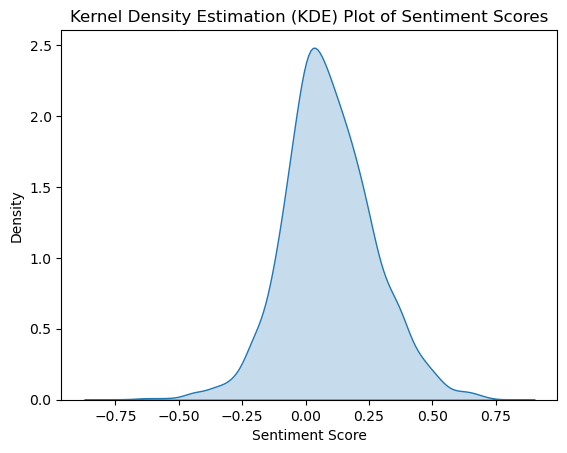

In [19]:
# KDE plot for Sentiment
sns.kdeplot(r['polarity'],fill=True)
plt.title('Kernel Density Estimation (KDE) Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

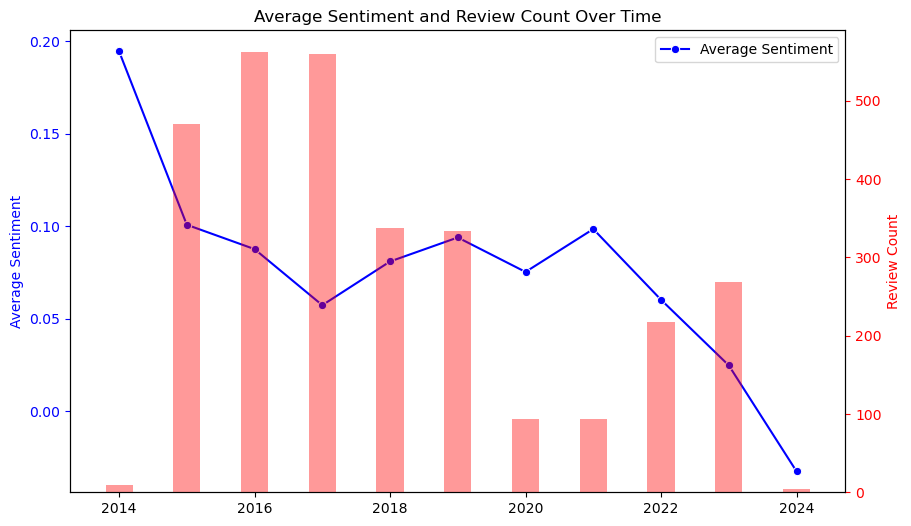

In [20]:
# Average Sentiment and Review Count Over Time

# Group data by year and calculate average sentiment and count of data points for each year
grouped_data = r.groupby(r['date'].dt.year).agg({'polarity': 'mean', 'date': 'count'})
grouped_data.columns = ['Average Sentiment', 'Review Count']

# Plotting the trend over time with data points
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average sentiment
sns.lineplot(x=grouped_data.index, y=grouped_data['Average Sentiment'], marker='o', ax=ax1, label='Average Sentiment', color='b')
ax1.set_xlabel('')
ax1.set_ylabel('Average Sentiment', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(False)

# Create a secondary y-axis for data points
ax2 = ax1.twinx()
ax2.bar(grouped_data.index, grouped_data['Review Count'], alpha=0.4, color='r', width=0.4)
ax2.set_ylabel('Review Count', color='r')
ax2.tick_params('y', colors='r')

# Add title and legend
plt.title('Average Sentiment and Review Count Over Time')
plt.show()

In [21]:
# Categorize sentiment
r['sentiment'] = pd.cut(r['polarity'], bins=[-1, -0.1, 0.1, 1], labels=['neg', 'neu', 'pos'])

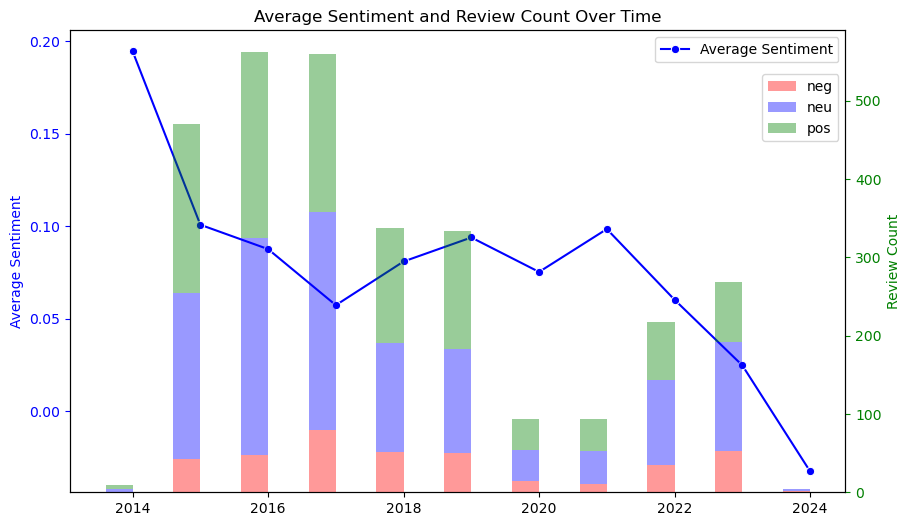

In [22]:
# Average Sentiment and Review Count Over Time

# Group data by year and calculate sentiment counts for each year
sentiment_counts_by_year = r.groupby([r['date'].dt.year, 'sentiment']).size().unstack(fill_value=0)

# Group data by year and calculate average sentiment and count of data points for each year
grouped_data = r.groupby(r['date'].dt.year).agg({'polarity': 'mean', 'date': 'count'})
grouped_data.columns = ['Average Sentiment', 'Review Count']

# Plotting the trend over time with data points
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average sentiment
sns.lineplot(x=grouped_data.index, y=grouped_data['Average Sentiment'], marker='o', ax=ax1, label='Average Sentiment', color='b')
ax1.set_xlabel('')
ax1.set_ylabel('Average Sentiment', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(False)

# Create a secondary y-axis for data points
ax2 = ax1.twinx()

# Define sentiment categories and corresponding colors
sentiment_categories = ['neg', 'neu', 'pos']
colors = ['r', 'b', 'g']

# Plot sentiment counts as bar plot on the same axes
bar_width = 0.4
for i, sentiment_category in enumerate(sentiment_categories):
    bottom = sentiment_counts_by_year[sentiment_categories[:i]].sum(axis=1)
    ax2.bar(grouped_data.index - bar_width / 2, sentiment_counts_by_year[sentiment_category], bottom=bottom, width=bar_width, alpha=0.4, color=colors[i], label=sentiment_category)

# Add labels for the secondary y-axis
ax2.set_ylabel('Review Count', color='g')
ax2.tick_params('y', colors='g')

# Add title and legend
plt.title('Average Sentiment and Review Count Over Time')
ax1.legend(loc='upper right')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.92))

plt.show()

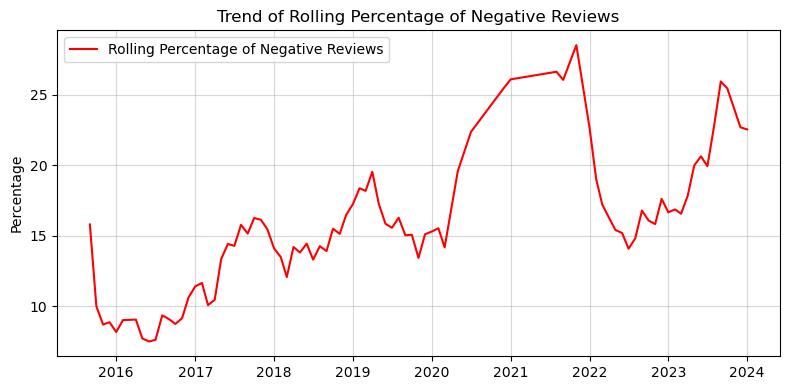

In [23]:
# Rolling Percentage of Negative Reviews Over Time

# Calculate the count of negative reviews per month
neg_r_count = r.loc[r['sentiment']=='neg','date'].dt.to_period('M').value_counts().sort_index()

# Calculate the total count of reviews per month
tot_r_count = r['date'].dt.to_period('M').value_counts().sort_index()

# Merge the counts on the 'date' column
merged_df = pd.merge(neg_r_count,tot_r_count,on='date',how='inner')
merged_df.columns=['neg_count','tot_count']

# Calculate the rolling percentage of negative reviews
rolling_per_neg = ((merged_df['neg_count'] / merged_df['tot_count']) * 100).rolling(window=7).mean()

# Convert the Period index to Timestamp for plotting
rolling_per_neg.index = rolling_per_neg.index.to_timestamp()

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(rolling_per_neg, color='red', label='Rolling Percentage of Negative Reviews')

# Additional styling
plt.title('Trend of Rolling Percentage of Negative Reviews')
plt.xlabel('')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

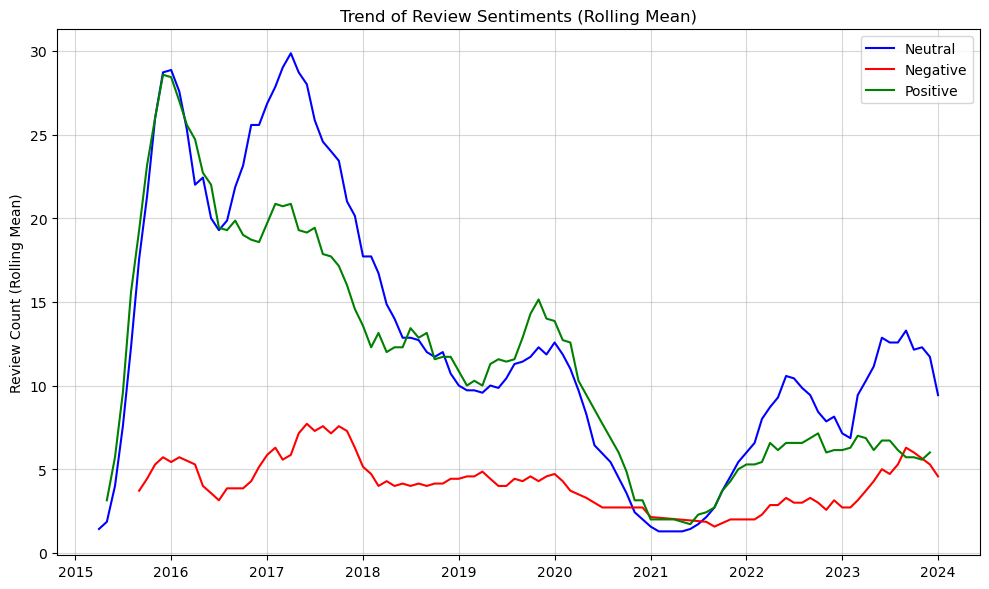

In [24]:
# Trend of Review Sentiments (Rolling Mean)

# Calculate rolling mean for negative, neutral, and positive sentiments
rolling_mean_neg = r.loc[r['sentiment']=='neg','date'].value_counts().sort_index().rolling(window=7).mean()
rolling_mean_neu = r.loc[r['sentiment']=='neu','date'].value_counts().sort_index().rolling(window=7).mean()
rolling_mean_pos = r.loc[r['sentiment']=='pos','date'].value_counts().sort_index().rolling(window=7).mean()

# Plot the smoothed curve with different colors and labels
plt.figure(figsize=(10, 6))
plt.plot(rolling_mean_neu, color='blue', label='Neutral')
plt.plot(rolling_mean_neg, color='red', label='Negative')
plt.plot(rolling_mean_pos, color='green', label='Positive')

# Additional styling
plt.title('Trend of Review Sentiments (Rolling Mean)')
plt.xlabel('')
plt.ylabel('Review Count (Rolling Mean)')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

sentiment
pos    1640
neu    1633
neg     455
Name: count, dtype: int64


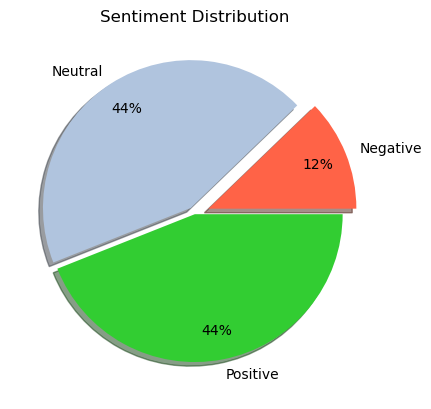

In [25]:
# Sentiment Distribution

# Count the occurrences of each sentiment
sentiment_counts = r['sentiment'].value_counts()
print(sentiment_counts)

# Pie chart
plt.pie(sentiment_counts, labels=['Positive','Neutral','Negative'],
        explode = (0,0.05,0.1), shadow=True, counterclock=False, pctdistance=0.8,
        autopct='%1.0f%%', colors=['limegreen', 'lightsteelblue', 'tomato'])
plt.title('Sentiment Distribution')
plt.show()

#### WordCloud of Reviews

In [26]:
# Creating Union Set of Stopwords
stopwords_n = set(STOPWORDS) | set(stopwords.words('english'))

stopwords_n.update(['flight','flights','ba','london','british','airway','airways','business','class','take','told','us','put',
                    'heathrow','flights','airline','aircraft','airport','seat','seats','time','u','another','use','ok','said','made',
                    'passenger','passengers','one','first','plane','lounge','good','verified','review',])

# Remove punctuation
df['reviews'] = df['reviews'].str.replace(f'[{string.punctuation}]', '')

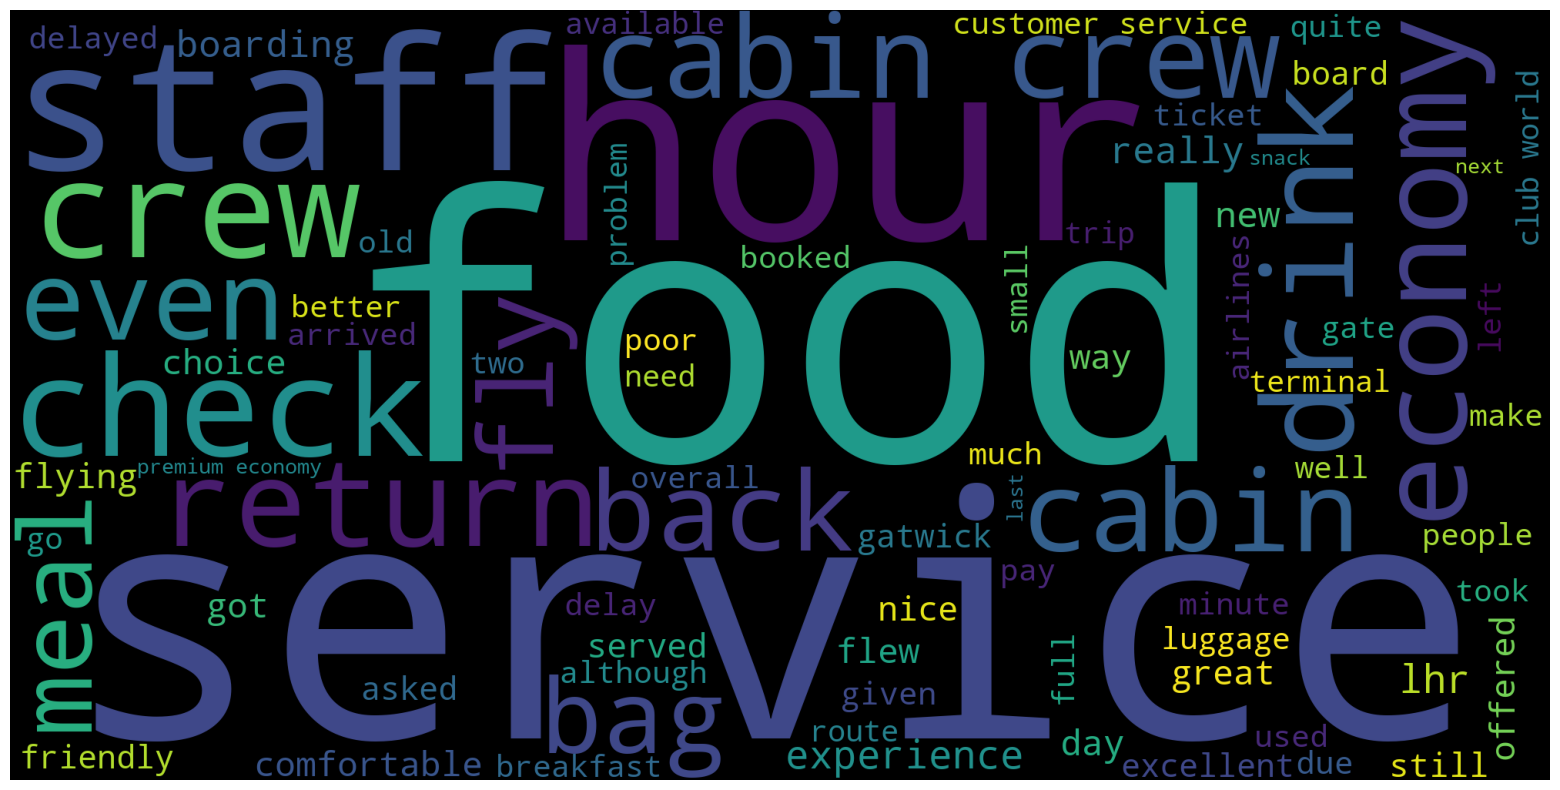

In [27]:
#Generate review corpus
reviews_corpus = r['reviews'].str.cat(sep=' ')

# Generate a WordCloud from the reviews_corpus
wordcloud = WordCloud(width=2000,height=1000,stopwords=stopwords_n, 
                      max_words=80).generate(reviews_corpus)

# Plot the WordCloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

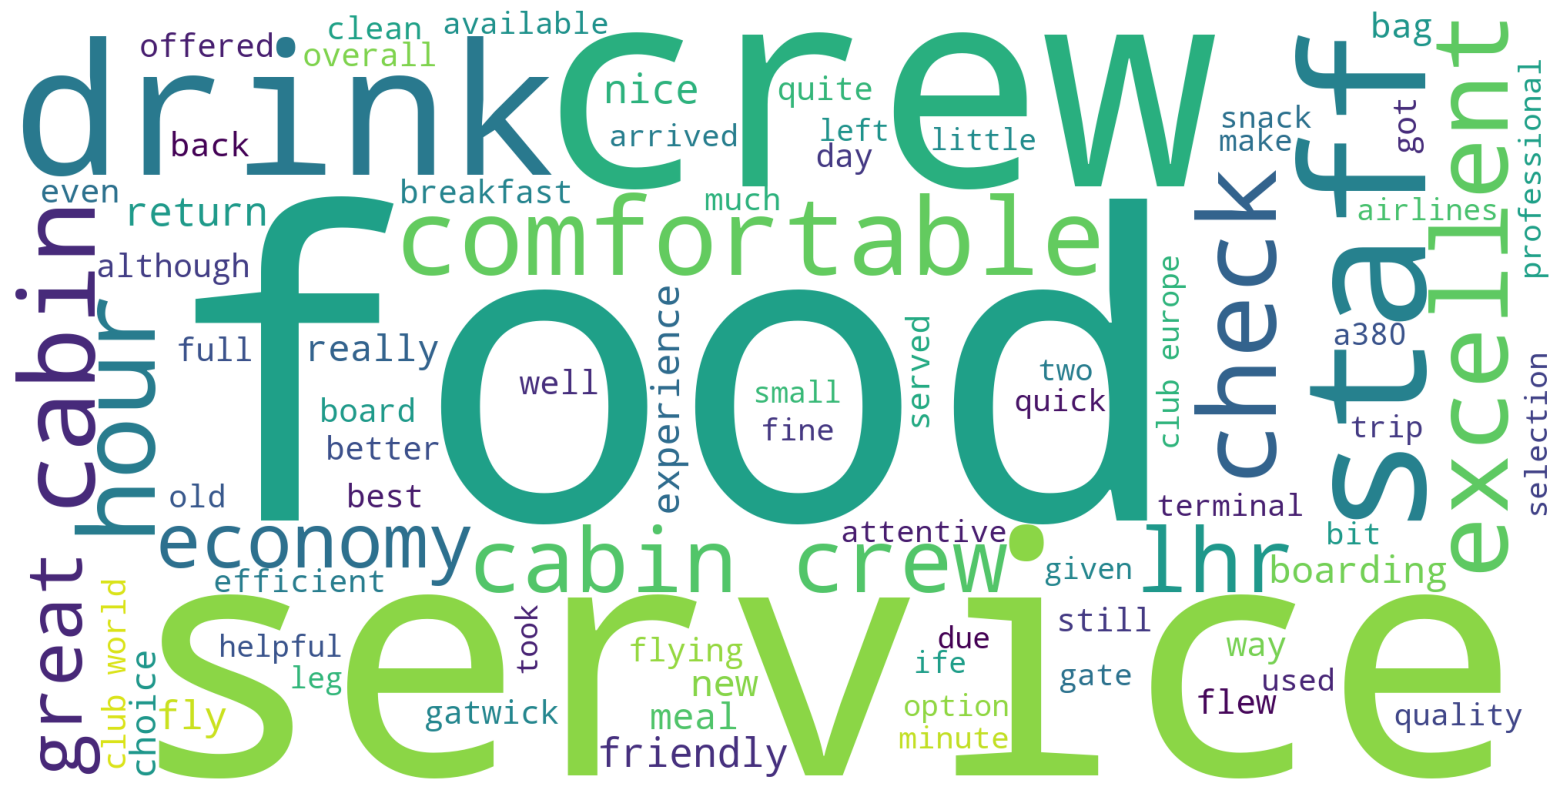

In [28]:
#Generate positive_review corpus
positive_reviews_corpus = r.loc[r['sentiment']=='pos','reviews'].str.cat(sep=' ')

# Generate a WordCloud from the positive_reviews_corpus
wordcloud = WordCloud(width=2000,height=1000,stopwords=stopwords_n,background_color='white',
                      max_words=80).generate(positive_reviews_corpus)

# Plot the WordCloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

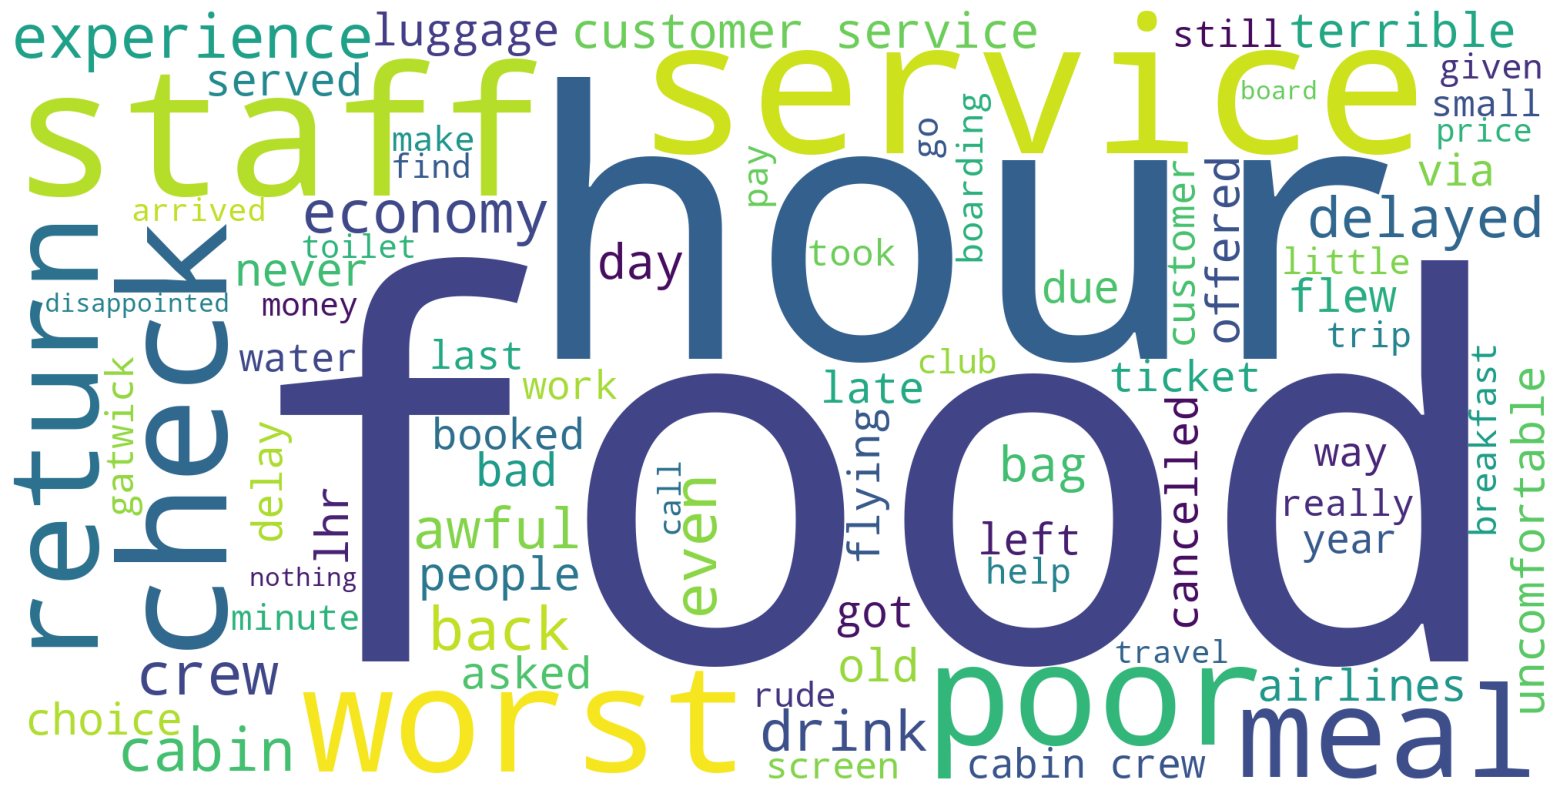

In [29]:
#Generate negative_review corpus
negative_reviews_corpus = r.loc[r['sentiment']=='neg','reviews'].str.cat(sep=' ')

# Generate a WordCloud from the negative_reviews_corpus
wordcloud = WordCloud(width=2000,height=1000,stopwords=stopwords_n,background_color='white',
                     max_words=80).generate(negative_reviews_corpus)

# Plot the WordCloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Topic Distribution of all reviews

In [30]:
# Create a TF-IDF matrix
tfidf_model = TfidfVectorizer(min_df=10,max_df=0.85,stop_words='english',ngram_range=(1,3))
tfidf_matrix = tfidf_model.fit_transform(r['reviews'])

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Displaying top words for each topic
feature_names = tfidf_model.get_feature_names_out()
topics = nmf_model.components_

for id in range(len(topics)):
    print(f'Top words for Topic {id+1} :')
    top_features_idx = topics[id].argsort()[-15:][::-1]
    print([feature_names[i] for i in top_features_idx],'\n')

Top words for Topic 1 :
['seat', 'economy', 'ba', 'seats', 'premium', 'premium economy', 'food', 'leg', 'haul', 'entertainment', 'cabin', 'long', 'just', 'meal', 'better'] 

Top words for Topic 2 :
['flight', 'ba', 'told', 'hours', 'customer', 'airport', 'cancelled', 'check', 'luggage', 'day', 'customer service', 'booked', 'refund', 'delayed', 'staff'] 

Top words for Topic 3 :
['class', 'business', 'business class', 'seats', 'seat', 'lounge', 'class seats', 'club', 'ba', 'business class seats', 'economy', 'middle', 'middle seat', 'economy class', 'class passengers'] 

Top words for Topic 4 :
['british', 'airways', 'british airways', 'london', 'review', 'verified', 'heathrow', 'verified review', 'london heathrow', 'airline', 'airlines', 'service', 'flight', 'review london', 'verified review london'] 

Top words for Topic 5 :
['good', 'crew', 'flight', 'cabin', 'lounge', 'club', 'time', 'lhr', 'excellent', 'cabin crew', 'boarding', 'food', 'service', 'friendly', 'drinks'] 



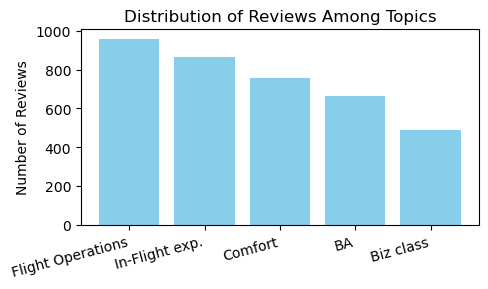

In [31]:
# Extracting the dominant topic for each review
topic_distribution = nmf_matrix.argmax(axis=1)+1

# Counter for topic counts
topic_counts = Counter(topic_distribution)

# Sort the Counter items by the number of reviews in descending order
sorted_topic_counts = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Dictionary mapping topic IDs to topic names
topic_names = {
    1: 'Comfort',
    2: 'Flight Operations',
    3: 'Biz class',
    4: 'BA',
    5: 'In-Flight exp.'}

# Dictionary mapping topic IDs to topic names
topic_names_list = [topic_names[id] for id,_ in sorted_topic_counts]

# Create a DataFrame for Plotly
data = {'Topics': topic_names_list, 'Number of Reviews': [count for _, count in sorted_topic_counts]}
data = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(5, 3))
plt.bar(data['Topics'], data['Number of Reviews'], color='skyblue')
plt.title('Distribution of Reviews Among Topics')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#### Topic Distribution of negative reviews

In [32]:
# Create a TF-IDF matrix
tfidf_model = TfidfVectorizer(min_df=10,max_df=0.85,stop_words='english',ngram_range=(1,3))
tfidf_matrix = tfidf_model.fit_transform(r.loc[r['sentiment']=='neg','reviews'])

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Displaying top words for each topic
feature_names = tfidf_model.get_feature_names_out()
topics = nmf_model.components_

for id in range(len(topics)):
    print(f'Top words for Topic {id+1} :')
    top_features_idx = topics[id].argsort()[-15:][::-1]
    print([feature_names[i] for i in top_features_idx],'\n')

Top words for Topic 1 :
['cabin', 'crew', 'seat', 'food', 'seats', 'ba', 'entertainment', 'economy', 'poor', 'meal', 'uncomfortable', 'cabin crew', 'old', 'service', 'just'] 

Top words for Topic 2 :
['class', 'business', 'business class', 'lounge', 'economy', 'club', 'food', 'seat', 'seats', 'worst', 'worst business class', 'worst business', 'poor', 'seating', 'world'] 

Top words for Topic 3 :
['flight', 'delayed', 'late', 'hours', 'hour', 'flight delayed', 'boarding', 'minutes', 'check', 'london', 'staff', 'ba', 'connecting', 'connecting flight', 'delay'] 

Top words for Topic 4 :
['british', 'airways', 'british airways', 'review', 'verified', 'verified review', 'london', 'airline', 'london heathrow', 'heathrow', 'worst', 'airlines', 'food', 'review london', 'verified review london'] 

Top words for Topic 5 :
['customer', 'customer service', 'service', 'ba', 'told', 'cancelled', 'phone', 'days', 'flight', 'refund', 'number', 'tried', 'trip', 'day', 'flights'] 



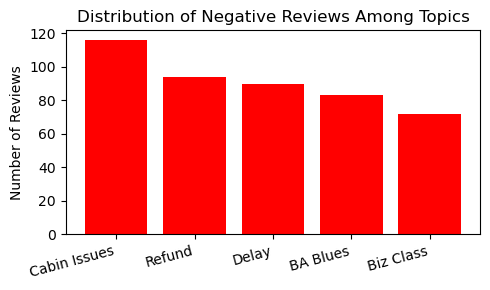

In [33]:
# Extracting the dominant topic for each review
topic_distribution = nmf_matrix.argmax(axis=1)+1

# Counter for topic counts
topic_counts = Counter(topic_distribution)

# Sort the Counter items by the number of reviews in descending order
sorted_topic_counts = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Dictionary mapping topic IDs to topic names
topic_names = {
    1: 'Cabin Issues',
    2: 'Biz Class',
    3: 'Delay',
    4: 'BA Blues',
    5: 'Refund'}

# Dictionary mapping topic IDs to topic names
topic_names_list = [topic_names[id] for id,_ in sorted_topic_counts]

# Create a DataFrame for Plotly
data = {'Topics': topic_names_list, 'Number of Reviews': [count for _, count in sorted_topic_counts]}
data = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(5, 3))
plt.bar(data['Topics'], data['Number of Reviews'], color='red')
plt.title('Distribution of Negative Reviews Among Topics')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#### Topic Distribution of positive reviews

In [34]:
# Create a TF-IDF matrix
tfidf_model = TfidfVectorizer(min_df=10,max_df=0.85,stop_words='english',ngram_range=(1,3))
tfidf_matrix = tfidf_model.fit_transform(r.loc[r['sentiment']=='pos','reviews'])

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Displaying top words for each topic
feature_names = tfidf_model.get_feature_names_out()
topics = nmf_model.components_

for id in range(len(topics)):
    print(f'Top words for Topic {id+1} :')
    top_features_idx = topics[id].argsort()[-15:][::-1]
    print([feature_names[i] for i in top_features_idx],'\n')

Top words for Topic 1 :
['good', 'cabin', 'lhr', 'crew', 'economy', 'food', 'seat', 'comfortable', 'great', 'excellent', 'seats', 'flight', 'a380', 'entertainment', 'premium economy'] 

Top words for Topic 2 :
['british', 'airways', 'british airways', 'flight', 'london', 'heathrow', 'airline', 'ba', 'review', 'verified review', 'verified', 'london heathrow', 'fly', 'airlines', 'flights'] 

Top words for Topic 3 :
['flight', 'check', 'time', 'boarding', 'lounge', 'crew', 'quick', 'minutes', 'bag', 'arrived', 'security', 'late', 'good', 'ba', 'drinks'] 

Top words for Topic 4 :
['class', 'business', 'business class', 'ba', 'seat', 'seats', 'lounge', 'economy', 'middle', 'food', 'class seats', 'just', 'fly', 'aisle', 'business class seats'] 

Top words for Topic 5 :
['club', 'world', 'club world', 'club europe', 'europe', 'seat', 'service', 'new', 'lounge', 'good', 'ba', 'excellent', 'ba club', 'new club', 'food'] 



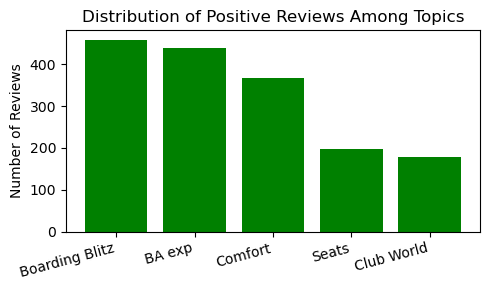

In [35]:
# Extracting the dominant topic for each review
topic_distribution = nmf_matrix.argmax(axis=1)+1

# Counter for topic counts
topic_counts = Counter(topic_distribution)

# Sort the Counter items by the number of reviews in descending order
sorted_topic_counts = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Dictionary mapping topic IDs to topic names
topic_names = {
    1: 'Comfort',
    2: 'BA exp',
    3: 'Boarding Blitz',
    4: 'Seats',
    5: 'Club World'}

# Mapping topic IDs to topic names for the sorted counts
topic_names_list = [topic_names[id] for id,_ in sorted_topic_counts]

# Create a DataFrame for Plotly
data = {'Topics': topic_names_list, 'Number of Reviews': [count for _, count in sorted_topic_counts]}
data = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(5, 3))
plt.bar(data['Topics'], data['Number of Reviews'], color='green')
plt.title('Distribution of Positive Reviews Among Topics')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#### Analysis of reviews after mid 2022

In [36]:
# Extracting negative reviews after mid-2022
neg_rev_after_mid_2022 = r.loc[(r['sentiment']=='neg') & (r['date'] > '2022-05-01'),'reviews']
print('Count of neg reviews after mid 2022: ',len(neg_rev_after_mid_2022),'\n')
neg_rev_after_mid_2022[:5]

Count of neg reviews after mid 2022:  76 



0       the plane was extremely dirty with chocolate...
21     once again a terrible business class experien...
29       never i saw such a terrible customer experi...
38      booked a flight from bucharest to manchester...
55       i hate british airways! we get to london on...
Name: reviews, dtype: object

In [37]:
# Create a TF-IDF matrix
tfidf_model = TfidfVectorizer(min_df=10,max_df=0.85,stop_words='english',ngram_range=(1,3))
tfidf_matrix = tfidf_model.fit_transform(neg_rev_after_mid_2022)

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

# Displaying top words for each topic
feature_names = tfidf_model.get_feature_names_out()
topics = nmf_model.components_

for id in range(len(topics)):
    print(f'Top words for Topic {id+1} :')
    top_features_idx = topics[id].argsort()[-15:][::-1]
    print([feature_names[i] for i in top_features_idx],'\n')

Top words for Topic 1 :
['ba', 'flight', 'cancelled', 'london', 'time', 'day', 'help', 'airline', 'airport', 'heathrow', 'don', 'connecting', 'hour', 'late', 'connecting flight'] 

Top words for Topic 2 :
['business', 'business class', 'class', 'seats', 'seat', 'check', 'poor', 'staff', 'plane', 'delayed', 'flight', 'horrible', 'heathrow', 'ba', 'terrible'] 

Top words for Topic 3 :
['british', 'british airways', 'airways', 'customer', 'customer service', 'service', 'check', 'fly', 'poor', 'terrible', 'hours', 'don', 'lost', 'told', 'staff'] 

Top words for Topic 4 :
['luggage', 'lost', 'staff', 'delayed', 'connecting', 'connecting flight', 'flight delayed', 'london', 'experience', 'check', 'flight', 'hour', 'told', 'airline', 'late'] 

Top words for Topic 5 :
['food', 'seat', 'hours', 'worst', 'airline', 'seats', 'flights', 'experience', 'time', 'did', 'fly', 'check', 'late', 'service', 'terrible'] 



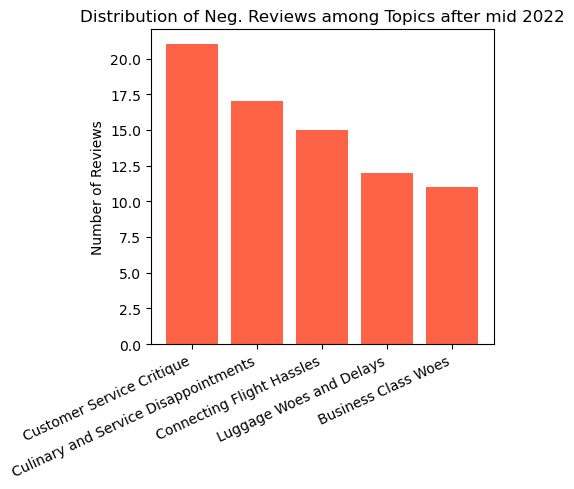

In [38]:
# Extracting the dominant topic for each review
topic_distribution = nmf_matrix.argmax(axis=1)+1

# Counting the occurrences of each topic
topic_counts = Counter(topic_distribution)

# Sorting the topics by the number of reviews in descending order
sorted_topic_counts = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

# Dictionary mapping topic IDs to topic names
topic_names = {
    1: 'Connecting Flight Hassles',
    2: 'Business Class Woes',
    3: 'Customer Service Critique',
    4: 'Luggage Woes and Delays',
    5: 'Culinary and Service Disappointments'}

# Mapping topic IDs to topic names for the sorted counts
topic_names_list = [topic_names[id] for id,_ in sorted_topic_counts]

# Create a DataFrame for Plotly
data = {'Topics': topic_names_list, 'Number of Reviews': [count for _, count in sorted_topic_counts]}
data = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(5, 5))
plt.bar(data['Topics'], data['Number of Reviews'], color='tomato')
plt.title('Distribution of Neg. Reviews among Topics after mid 2022')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

sentiment
neu    199
pos    119
neg     76
Name: count, dtype: int64


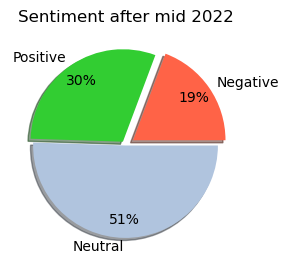

In [39]:
# Sentiment Distribution after mid 2022

# Count the occurrences of each sentiment
sentiment_counts = r.loc[(r['date'] > '2022-05-01'),'sentiment'].value_counts()
print(sentiment_counts)

# Pie chart
plt.figure(figsize=(3, 3))
plt.pie(sentiment_counts, labels=['Neutral','Positive','Negative'],
        explode = (0,0.05,0.1), shadow=True, counterclock=False, pctdistance=0.8,
        autopct='%1.0f%%', colors=['lightsteelblue','limegreen', 'tomato'])
plt.title('Sentiment after mid 2022')
plt.show()